

Average Algorithm
-----------------

Algorithm Theoretical Basis for "Average Algorithm"

## Summary
The average algorithm creates an averaged stream from each of the traces in the timeseries that is passed to the algorithm. There are checks to ensure that the traces contain the same channels with the same timestamps but come from different observatories. This is used primarily for creating DST (Disturbance Storm Time) event data.

## Math and Theory
The timeseries that is passed to the average algorithm process is looped over each observatory. The data related to each observatory is compiled into a 2D numpy array. As the data is input to the numpy array it is multiplied by a correctional value that defaults to 1 but can be changed by specifying an average_observatory_scale parameter. The correctional value is a weighting scale that varies from 0-1 in order to place a stronger reliance on certain observatories. The data in the 2D numpy array is then averaged into a single array using numpy's mean function. A new stream is created with this new data using a get_trace function that resets the stats to a new channel, station, network, interval, and location.

## Practical Considerations
The averaging function can be called from the command line using the geomag.py script and adding in the optional call to --algorithm average. The algorithm can also be used from your own python script as shown below. This algorithm will take streams of multiple observatories but only one channel may be average at one time. When initializing the algorithm three parameters may be set, observatories, scales, and channel. The observatories and channel may be used as a sort of check to ensure that only the observatories and/or channel you specified are used to create the averaged stream. The scales is used to set the correction factors and must be set in the same order that the observatories are set. Sometimes when using the command line it is necessary to specify the --outchannels argument as some factories, like the iaga writer, will try to set a different outchannel. 

## Imports

In [1]:
from geomagio.edge import EdgeFactory
from geomagio.algorithm import AverageAlgorithm
from obspy.core import UTCDateTime, Stream
import matplotlib.pyplot as plt

## Initialize variables and Plot the Input Timeseries

In [2]:
channels = ['MSD']
observatories = ['SJG','HON','KAK','HER']
start = UTCDateTime('2018-08-02T18:00:00Z')
end = UTCDateTime('2018-08-03T12:00:00Z')
stream3 = Stream()
stream4 = Stream()

input_factory = EdgeFactory()
for obs in observatories:
    stream4 += input_factory.get_timeseries(
        starttime=start,
        endtime=end,
        channels=channels,
        observatory=obs,
        type='variation',
        interval='minute')
for obs in ['HON','SJG','GUA']:
    stream3 += input_factory.get_timeseries(
        starttime=start,
        endtime=end,
        channels=['MDT',],
        observatory=obs,
        type='variation',
        interval='minute')
    
# # These lines will plot each trace in the stream so that you can see which
# #  observatory is contributing to different features
# stream4.plot()
# stream3.plot()

## Initialize the Algorithm factory, run the averaging process and plot the output of the averaged stream

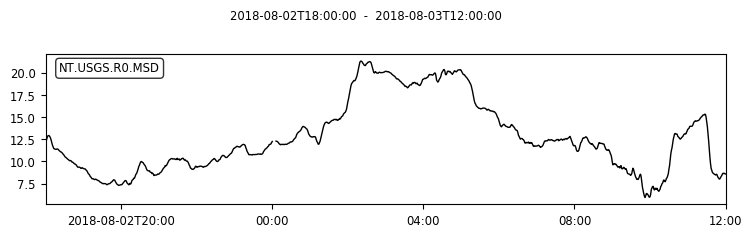

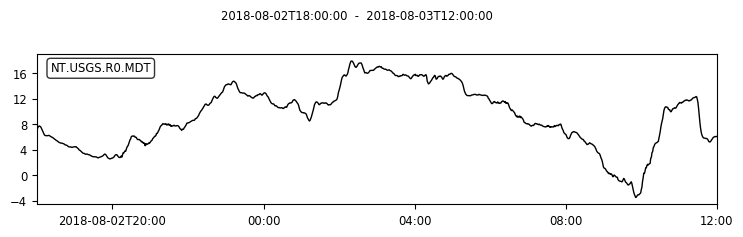

In [3]:
algorithm_factory = AverageAlgorithm()
dst4_stream = algorithm_factory.process(stream4)

algorithm_factory = AverageAlgorithm()
dst3_stream = algorithm_factory.process(stream3)
dst4_stream.plot()
dst3_stream.plot()

## Set observatory scale/corrections and re-run the process. The Plot shows the scaled version of the averaging function.

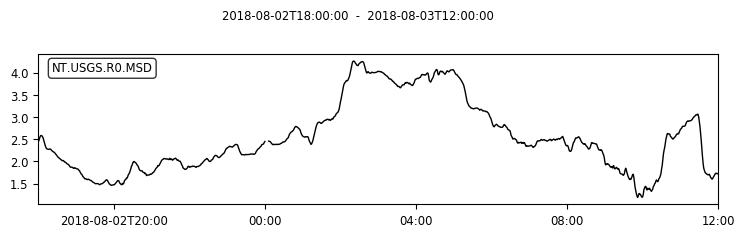

In [4]:
scaled_factory = AverageAlgorithm(scales = [.2, 2, .5, .5])
averaged_scaled_series = scaled_factory.process(dst4_stream)
averaged_scaled_series.plot()

2 Trace(s) in Stream:
NT.old.R0.DST  | 2018-08-02T18:00:00.000000Z - 2018-08-03T12:00:00.000000Z | 60.0 s, 1081 samples
NT.USGS.R0.DST | 2018-08-02T18:00:00.000000Z - 2018-08-03T12:00:00.000000Z | 60.0 s, 1081 samples


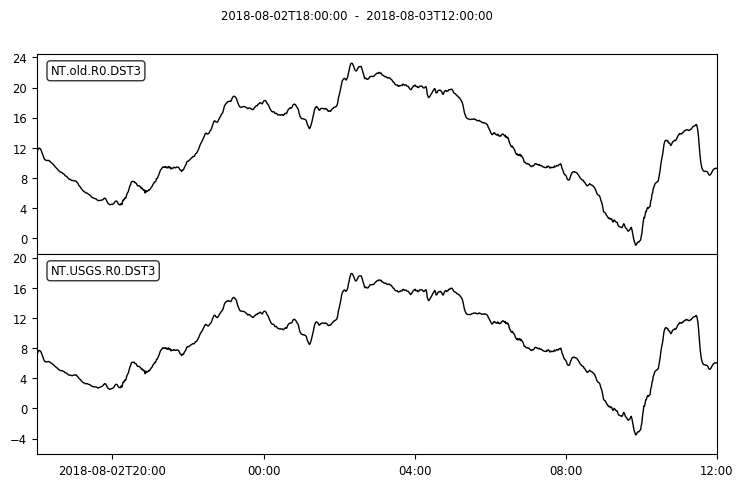

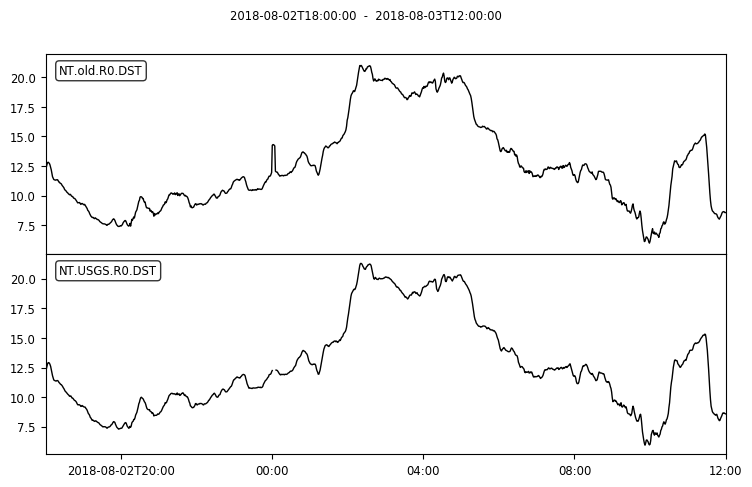

In [5]:
# This obtains the currently running (old version) of DST data
dst_factory = EdgeFactory()
chan = ['MGD','MSD',]
OG_DST = input_factory.get_timeseries(
        starttime=UTCDateTime('2018-08-02T18:00:00Z'),
        endtime=UTCDateTime('2018-08-03T12:00:00Z'),
        channels=chan,
        observatory='USGS',
        type='variation',
        interval='minute')

# This just renames the channels for clarity in comparing the old and new DST
OG_DST.select(channel='MGD')[0].stats.channel = 'DST'
OG_DST.select(channel='DST')[0].stats.station = 'old'
OG_DST.select(channel='MSD')[0].stats.channel = 'DST3'
OG_DST.select(channel='DST3')[0].stats.station = 'old'
dst3_stream[0].stats.channel = 'DST3'
dst4_stream[0].stats.channel = 'DST'

# # Plots each stream separately
# OG_DST.plot()
# dst3_stream.plot()
# dst4_stream.plot()

# For easier comparison
all_streams = OG_DST + dst3_stream + dst4_stream
all_dst3 = all_streams.select(channel='DST3')
all_dst = all_streams.select(channel='DST')
print(all_dst)
all_dst3.plot()
all_dst.plot()
    